# Notebook to evaluate the activity model

This notebook is designed as an evaluation notebook.

In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import time
import os
import ants
import pandas as pd
import statsmodels.api as smapi
import numpy as np
from nibabel import load as load_nii
from nibabel import Nifti1Image
from skimage.filters import threshold_otsu
from skimage.measure import label as bwlabeln
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage.morphology import binary_closing
from scipy.ndimage.morphology import binary_fill_holes
from scipy.stats import ttest_rel, normaltest
from scipy.stats import spearmanr, kendalltau
from shutil import copyfile
import seaborn as sns

## Utility functions
### Statistics

In [2]:
def plot_correlation(metrics, network, lowess=False):
    model_vols = [m[5] for m in metrics['positive'] if m[1] == network]
    manual_vols = [m[6] for m in metrics['positive'] if m[1] == network]
    model_lesions = [m[10] for m in metrics['positive'] if m[1] == network]
    manual_lesions = [m[11] for m in metrics['positive'] if m[1] == network]
    array = [
        [
            (m[6] - np.mean(manual_vols)) / np.std(manual_vols),
            (m[5] - np.mean(model_vols)) / np.std(model_vols),
            'Volume'
        ]
        for m in metrics['positive'] if m[1] == network
    ] + [
        [
            (m[11] - np.mean(manual_lesions)) / np.std(manual_lesions),
            (m[10] - np.mean(model_lesions)) / np.std(model_lesions),
            'Lesions'
        ]
        for m in metrics['positive'] if m[1] == network
    ]

    columns = [
        'Manual',
        'Model',
        'Value per patient'
    ]
    dataframe = pd.DataFrame(array, columns=columns)

    snd_handle = sns.lmplot(
        x='Model', y='Manual', data=dataframe, hue='Value per patient',
        ci=68, truncate=False, lowess=lowess, robust=(not lowess)
    ) 
    
    lesions_dataframe = dataframe[dataframe['Value per patient'] == 'Lesions']
    x = lesions_dataframe['Model'].to_numpy()
    y = lesions_dataframe['Manual'].to_numpy()
    
    x[np.isnan(x)] = 0
    y[np.isnan(y)] = 0
    
    results_lesions = smapi.OLS(y, smapi.add_constant(x)).fit()
    spr_lesions, _ = spearmanr(x, y)
    
    volume_dataframe = dataframe[dataframe['Value per patient'] == 'Volume']
    x = volume_dataframe['Model'].to_numpy()
    y = volume_dataframe['Manual'].to_numpy()
    
    x[np.isnan(x)] = 0
    y[np.isnan(y)] = 0
    
    results_volume = smapi.OLS(y, smapi.add_constant(x)).fit()
    spr_volume, _ = spearmanr(x, y)

    if lowess:
        plt.title(
            u'{:} Lesions [\u03C1 = {:5.3f}] / Volume [\u03C1 = {:5.3f}]'.format(
                network, spr_lesions, spr_volume     
            )
        )
    else:
        plt.title(
            u'{:} Lesions [R\u00b2 = {:5.3f}] / Volume [R\u00b2 = {:5.3f}]'.format(
                network,
                results_lesions.rsquared,
                results_volume.rsquared     
            )
        )
    snd_handle.fig.subplots_adjust(top=.95, bottom=.1)

### Others

In [3]:
def get_int(string):
    """
    Function to get the int number contained in a string. If there are more
    than one int number (or there is a floating point number), this function
    will concatenate all digits and return an int, anyways.
    :param string: String that contains an int number
    :return: int number
    """
    return int(''.join(filter(str.isdigit, string)))


def get_dirs(path):
    """
    Function to get the folder name of the patients given a path.
    :param path: Folder where the patients should be located.
    :return: List of patient names.
    """
    # All patients (full path)
    patient_paths = sorted(
        filter(
            lambda d: os.path.isdir(os.path.join(path, d)),
            os.listdir(path)
        )
    )
    # Patients used during training
    return patient_paths

## Data loading

In [4]:
path = '/media/transcend/MSReports/Longitudinal/MICCAI_Challenge2021/training/'
cases = [
    p for p in sorted(os.listdir(path))
    if os.path.isdir(os.path.join(path, p))
]
print(cases)

['013', '015', '016', '018', '019', '020', '021', '024', '026', '027', '029', '030', '032', '035', '037', '039', '043', '047', '048', '049', '051', '052', '057', '061', '068', '069', '070', '074', '077', '083', '084', '088', '089', '090', '091', '094', '095', '096', '099', '100']


In [5]:
positive_cases = []
negative_cases = []
for p in cases:
    p_path = os.path.join(path, p)
    print('\033[KChecking {:}'.format(p_path), end='\r')
    gt_bool = load_nii(
        os.path.join(p_path, 'ground_truth.nii.gz')
    ).get_fdata().astype(bool)
    if np.sum(gt_bool) > 0:
        positive_cases.append(p)
    else:
        negative_cases.append(p)
print('Positive cases', positive_cases)
print('Negative cases', negative_cases)

Positive cases ['013', '016', '018', '020', '021', '024', '026', '027', '029', '030', '032', '035', '037', '039', '043', '047', '048', '057', '061', '069', '074', '077', '083', '088', '091', '094', '095', '099', '100']
Negative cases ['015', '019', '049', '051', '052', '068', '070', '084', '089', '090', '096']


## Metrics

### Loading and data preparation

In [6]:
all_metrics = {
    'positive': [],
    'negative': []
}
manual_vols = []
model_vols = []
manual_lesions = []
model_lesions = []
positive_metrics = [
    'Patient', 'Network',
    'TPF (V)', 'FPF (V)', 'DSC', 'TP (V)', 'V','GT (V)',
    'TPF (D)', 'FPF (D)', 'TP (D)', 'D', 'GT (D)', 'TP (C)'
]
negative_metrics = [
    'Patient', 'Network',
    'FP (V)', 'FP (D)', 'FP (C)'
]
training_labels = {
    '': 'Baseline',
    '_ft': 'Fine-tuning',
    '_ft-freeze': 'Fine-tuning (frozen)',
    '_xval': 'Trained',
}
with open(
        os.path.join(path, 'activity_metrics.csv'), 'w'
) as csvfile:
    evalwriter = csv.writer(csvfile)
    evalwriter.writerow(positive_metrics)
    for p in cases:
        p_path = os.path.join(path, p)
        print('\033[KChecking {:}'.format(p_path), end='\r')
        gt_bool = load_nii(
            os.path.join(p_path, 'ground_truth.nii.gz')
        ).get_fdata().astype(bool)
        gt_lab = bwlabeln(gt_bool)
        gt_v = np.sum(gt_bool)
        gt_d = len(np.unique(gt_lab[gt_lab > 0]))
        gtc = gt_v > 0
        
        for tr_key, tr_value in training_labels.items():
            auto_name = os.path.join(
                p_path, 'positive_activity{:}.nii.gz'.format(tr_key)
            )
            auto_bool = load_nii(auto_name).get_fdata().astype(bool)
            auto_lab = bwlabeln(auto_bool)
            auto_labs = np.unique(auto_lab)
            
            v = np.sum(auto_bool)

            # Positive cases
            if gtc:
                # Some intermediate steps.
                overlap = np.logical_and(gt_bool, auto_bool)
                nonoverlap = np.logical_and(np.logical_not(gt_bool), auto_bool)
                               
                # Pretty common and normal voxelwise / segmentation metrics.
                sum_v = v + gt_v
                
                tp_v = np.sum(overlap)
                tpf_v = tp_v / gt_v if gt_v > 0 else 0
                fp_v = np.sum(nonoverlap)
                fpf_v = fp_v / v if v > 0 else 0
                dsc = 2 * tp_v / sum_v if sum_v > 0 else 0

                # And finally a few regionwise / detection metrics.
                tp_labs = np.unique(gt_lab[auto_bool])
                notfp_labs = np.unique(auto_lab[gt_bool])
                fp_mask = np.logical_not(np.isin(auto_lab, notfp_labs))
                fp_labs = np.unique(auto_lab[fp_mask])
                tp = len(tp_labs[tp_labs > 0])
                tp_d = len(tp_labs[tp_labs > 0])
                fp = len(fp_labs[fp_labs > 0])
                tpf_d = 100 * tp / gt_d if gt_d > 0 else 0
                d = len(np.unique(auto_lab[auto_lab > 0]))
                fpf_d = 100 * fp / d if d > 0 else 0

                tpc = v > 0

                all_metrics['positive'].append([
                    p, tr_value, tpf_v, fpf_v, dsc, tp_v, v, gt_v,
                    tpf_d, fpf_d, tp_d, d, gt_d, tpc
                ])
                evalwriter.writerow([
                    p, tr_value, tpf_v, fpf_v, dsc, tp_v, v, gt_v,
                    tpf_d, fpf_d, tp_d, d, gt_d, tpc
                ])
            else:
                # And finally a few regionwise / detection metrics.
                fp_d = len(auto_labs[auto_labs > 0])
                fp_c = fp_d > 0
                fp_v = v

                all_metrics['negative'].append([
                    p, tr_value, fp_v, fp_d, fp_c
                ])

### Patient-based metrics

In [7]:
pd.DataFrame(all_metrics['positive'], columns=positive_metrics)

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
0,013,Baseline,0.650000,0.587302,0.504854,26,63,40,100.000000,50.000000,1,2,1,True
1,013,Fine-tuning,0.650000,0.500000,0.565217,26,52,40,100.000000,50.000000,1,2,1,True
2,013,Fine-tuning (frozen),0.675000,0.578125,0.519231,27,64,40,100.000000,50.000000,1,2,1,True
3,013,Trained,0.750000,0.949153,0.095238,30,590,40,100.000000,93.333333,1,15,1,True
4,016,Baseline,0.631225,0.078585,0.749201,469,509,743,83.333333,0.000000,5,5,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,099,Trained,0.228916,0.999979,0.000042,19,912529,83,100.000000,99.927850,1,1386,1,True
112,100,Baseline,0.530837,0.020325,0.688571,482,492,908,100.000000,33.333333,2,3,2,True
113,100,Fine-tuning,0.512115,0.029228,0.670512,465,479,908,100.000000,50.000000,2,4,2,True
114,100,Fine-tuning (frozen),0.482379,0.049892,0.639883,438,461,908,100.000000,50.000000,2,4,2,True


In [8]:
positive_df = pd.DataFrame(all_metrics['positive'], columns=positive_metrics)
positive_df[positive_df['DSC'] < 0.6]

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
0,013,Baseline,0.650000,0.587302,0.504854,26,63,40,100.00,50.000000,1,2,1,True
1,013,Fine-tuning,0.650000,0.500000,0.565217,26,52,40,100.00,50.000000,1,2,1,True
2,013,Fine-tuning (frozen),0.675000,0.578125,0.519231,27,64,40,100.00,50.000000,1,2,1,True
3,013,Trained,0.750000,0.949153,0.095238,30,590,40,100.00,93.333333,1,15,1,True
7,016,Trained,0.695828,0.534653,0.557713,517,1111,743,100.00,57.142857,6,14,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,095,Trained,0.170828,0.998161,0.003638,3366,1830782,19704,93.75,98.963242,30,1061,32,True
108,099,Baseline,0.301205,0.000000,0.462963,25,25,83,100.00,0.000000,1,1,1,True
109,099,Fine-tuning,0.313253,0.000000,0.477064,26,26,83,100.00,0.000000,1,1,1,True
111,099,Trained,0.228916,0.999979,0.000042,19,912529,83,100.00,99.927850,1,1386,1,True


In [9]:
positive_df[positive_df['Network'] == 'Trained']

,Patient,Network,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
3,013,Trained,0.750000,0.949153,0.095238,30,590,40,100.000000,93.333333,1,15,1,True
7,016,Trained,0.695828,0.534653,0.557713,517,1111,743,100.000000,57.142857,6,14,6,True
11,018,Trained,0.346154,0.700713,0.321019,126,421,364,100.000000,87.500000,2,16,2,True
15,020,Trained,0.407960,0.867099,0.200489,82,617,201,100.000000,97.916667,1,48,1,True
19,021,Trained,0.740907,0.284785,0.727834,1650,2307,2227,100.000000,63.636364,4,11,4,True
23,024,Trained,0.398293,0.999471,0.001056,280,529681,703,100.000000,99.905078,6,2107,6,True
27,026,Trained,0.545213,0.998080,0.003826,205,106783,376,88.888889,99.801193,8,503,9,True
31,027,Trained,0.558074,0.998430,0.003130,591,376524,1059,75.000000,99.941142,3,1699,4,True
35,029,Trained,0.000000,1.000000,0.000000,0,921940,802,0.000000,100.000000,0,1980,2,True
39,030,Trained,0.466667,0.999806,0.000388,329,1697010,705,100.000000,99.974786,3,3966,3,True


In [10]:
pd.DataFrame(all_metrics['negative'], columns=negative_metrics)

,Patient,Network,FP (V),FP (D),FP (C)
0,015,Baseline,0,0,False
1,015,Fine-tuning,0,0,False
2,015,Fine-tuning (frozen),0,0,False
3,015,Trained,56,3,True
4,019,Baseline,32,1,True
5,019,Fine-tuning,18,1,True
6,019,Fine-tuning (frozen),0,0,False
7,019,Trained,118,11,True
8,049,Baseline,12,1,True
9,049,Fine-tuning,0,0,False


In [11]:
negative_df = pd.DataFrame(all_metrics['negative'], columns=negative_metrics)
negative_df[negative_df['FP (C)']]

,Patient,Network,FP (V),FP (D),FP (C)
3,015,Trained,56,3,True
4,019,Baseline,32,1,True
5,019,Fine-tuning,18,1,True
7,019,Trained,118,11,True
8,049,Baseline,12,1,True
11,049,Trained,650106,2285,True
15,051,Trained,485866,1466,True
19,052,Trained,1170433,736,True
23,068,Trained,1704643,691,True
25,070,Fine-tuning,58,6,True


### Mean metrics

In [12]:
positive_df = pd.DataFrame(all_metrics['positive'], columns=positive_metrics)
positive_df.groupby('Network', sort=False).mean()

,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
Network,,,,,,,,,,,,
Baseline,0.447054,0.241587,0.505466,993.517241,1.341034e+03,2049.37931,75.842728,29.119513,3.931034,8.344828,5.206897,0.931034
Fine-tuning,0.385398,0.232584,0.448027,909.551724,1.253552e+03,2049.37931,75.563660,36.038769,3.931034,11.275862,5.206897,0.931034
Fine-tuning (frozen),0.391566,0.240381,0.437137,827.793103,1.267759e+03,2049.37931,67.922009,31.661212,3.586207,10.448276,5.206897,0.862069
Trained,0.445167,0.942193,0.066475,784.965517,1.410844e+06,2049.37931,94.825744,95.697543,4.965517,908.000000,5.206897,1.000000


In [13]:
positive_df[positive_df['DSC'] > 0.6].groupby('Network', sort=False).mean()

,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
Network,,,,,,,,,,,,
Baseline,0.649356,0.095513,0.749590,1605.642857,1772.857143,2678.000000,91.542659,17.702914,5.000000,6.571429,5.714286,True
Fine-tuning,0.634284,0.105195,0.738327,1935.909091,2084.818182,3280.727273,94.065657,33.869464,5.909091,9.545455,6.545455,True
Fine-tuning (frozen),0.651574,0.137007,0.726550,790.333333,902.583333,1283.000000,94.212963,27.700818,3.166667,5.083333,3.500000,True
Trained,0.740907,0.284785,0.727834,1650.000000,2307.000000,2227.000000,100.000000,63.636364,4.000000,11.000000,4.000000,True


In [14]:
positive_df[positive_df['DSC'] > 0.6].groupby('Network', sort=False).sum()

,TPF (V),FPF (V),DSC,TP (V),V,GT (V),TPF (D),FPF (D),TP (D),D,GT (D),TP (C)
Network,,,,,,,,,,,,
Baseline,9.090979,1.337179,10.494254,22479,24820,37492,1281.597222,247.840803,70,92,80,14
Fine-tuning,6.977122,1.157145,8.121596,21295,22933,36088,1034.722222,372.564103,65,105,72,11
Fine-tuning (frozen),7.818892,1.644084,8.718597,9484,10831,15396,1130.555556,332.409812,38,61,42,12
Trained,0.740907,0.284785,0.727834,1650,2307,2227,100.000000,63.636364,4,11,4,1


In [15]:
negative_df = pd.DataFrame(all_metrics['negative'], columns=negative_metrics)
negative_df.groupby('Network', sort=False).mean()

,FP (V),FP (D),FP (C)
Network,,,
Baseline,5.545455e+00,0.272727,0.272727
Fine-tuning,1.254545e+01,1.181818,0.454545
Fine-tuning (frozen),2.245455e+01,0.909091,0.181818
Trained,1.641925e+06,734.272727,1.000000


### Correlations

<IPython.core.display.Javascript object>


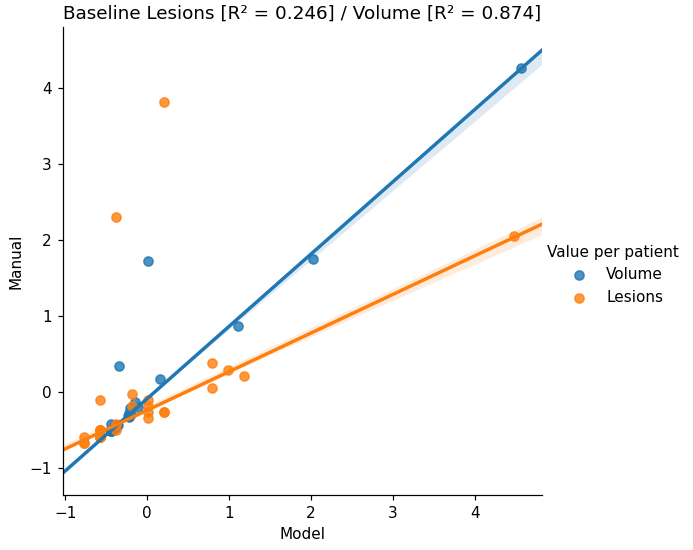

<IPython.core.display.Javascript object>


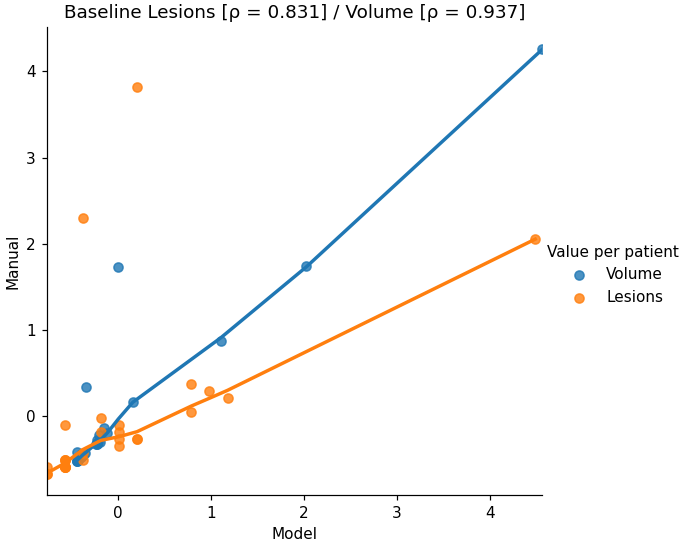

<IPython.core.display.Javascript object>


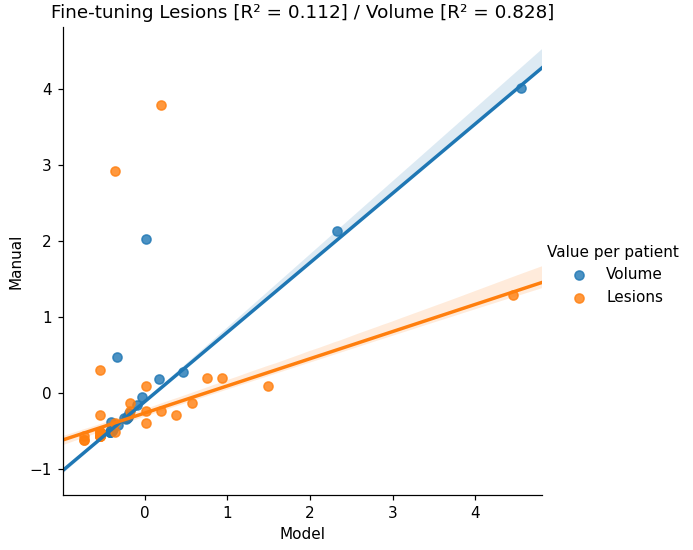

<IPython.core.display.Javascript object>


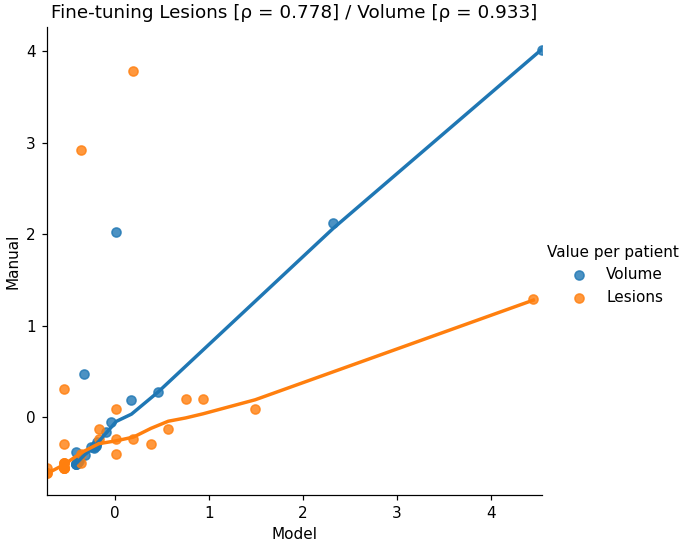

<IPython.core.display.Javascript object>


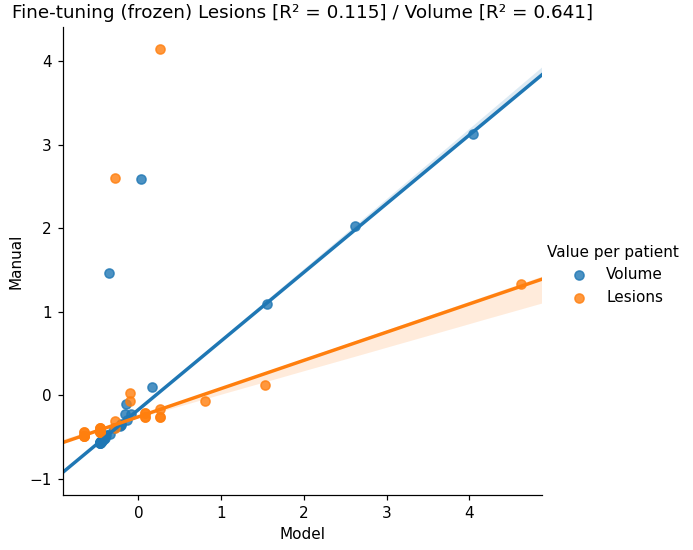

<IPython.core.display.Javascript object>


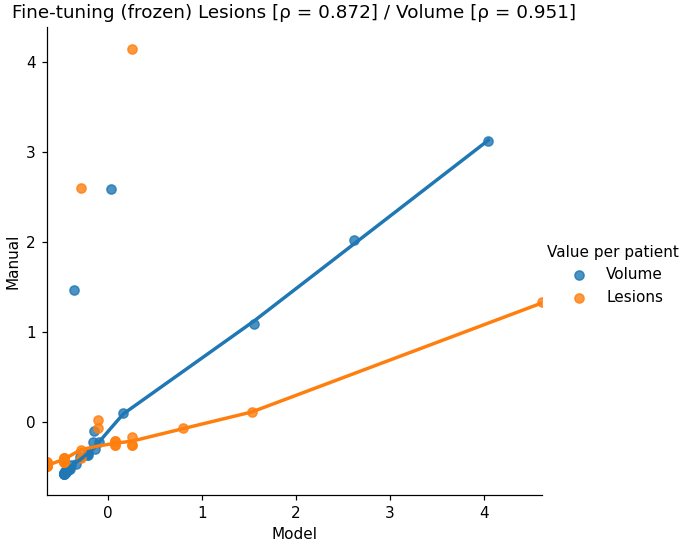

<IPython.core.display.Javascript object>


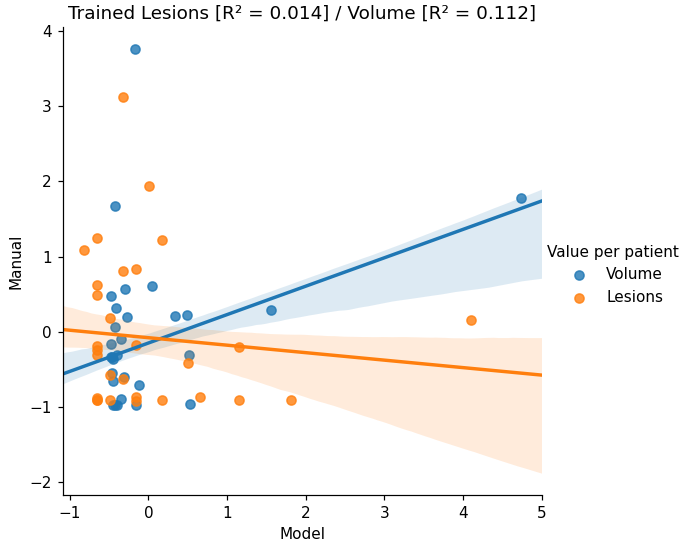

<IPython.core.display.Javascript object>


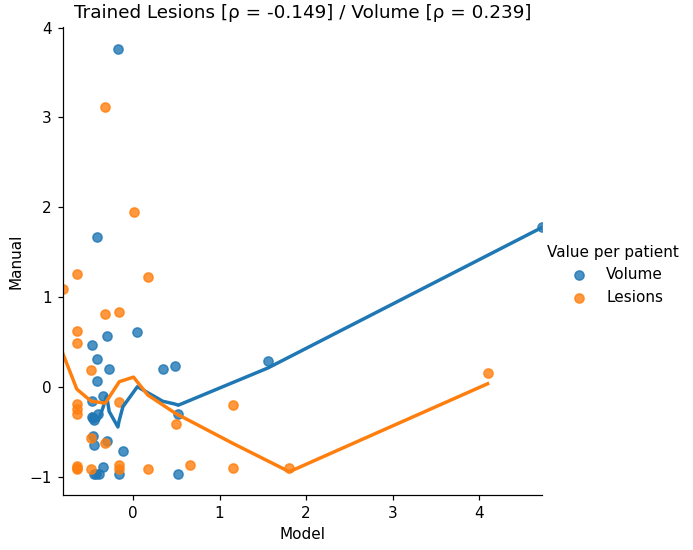

In [16]:
plot_correlation(all_metrics, 'Baseline')
plot_correlation(all_metrics, 'Baseline', lowess=True)
plot_correlation(all_metrics, 'Fine-tuning')
plot_correlation(all_metrics, 'Fine-tuning', lowess=True)
plot_correlation(all_metrics, 'Fine-tuning (frozen)')
plot_correlation(all_metrics, 'Fine-tuning (frozen)', lowess=True)
plot_correlation(all_metrics, 'Trained')
plot_correlation(all_metrics, 'Trained', lowess=True)

## Evaluation on the testing set (~100 cases)

The results of this experiment will serve to test the best post-processing based on the following ideas:
- Constraining positive activity to the follow-up lesion mask (detected lesions)
- Constraining positive activity based on the baseline mask (remove activity from detected lesions)
- Improving the brain mask (Geng's model)
- Eroding the brain mask to reduce "boundary lesions"
